In [2]:
import copy
import random
import heapq
import time
import pandas as pd
import requests
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint
from PIL import Image
from collections import deque, Counter
from queue import PriorityQueue
from pprint import pprint
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont

In [3]:
class Variable():

    ACROSS = "across"
    DOWN = "down"

    def __init__(self, i, j, direction, length):
        """Create a new variable with starting point, direction, and length."""
        self.i = i
        self.j = j
        self.direction = direction
        self.length = length
        self.cells = []
        for k in range(self.length):
            self.cells.append(
                (self.i + (k if self.direction == Variable.DOWN else 0),
                 self.j + (k if self.direction == Variable.ACROSS else 0))
            )

    def __hash__(self):
        return hash((self.i, self.j, self.direction, self.length))

    def __eq__(self, other):
        return (
            (self.i == other.i) and
            (self.j == other.j) and
            (self.direction == other.direction) and
            (self.length == other.length)
        )

    def __str__(self):
        return f"({self.i}, {self.j}) {self.direction} : {self.length}"

    def __repr__(self):
        direction = repr(self.direction)
        return f"Variable({self.i}, {self.j}, {direction}, {self.length})"

class Crossword():
    def __init__(self, grid, words_file, file_path = True):
        self.structure = []

        self.height = len(grid) # the number of rows in the grid
        self.width = len(grid[0]) # the number of columns in the grid
        for i in range(len(grid)):
            row = []
            for j in range(len(grid[0])):
                if grid[i][j] == '':
                    row.append(False)
                else:
                    row.append(True)
            self.structure.append(row)

        if not file_path:
            self.words = [word.upper() for word in words_file]

        else:
            # Save vocabulary list
            with open(words_file) as f:
                self.words = set(f.read().upper().splitlines()) # to remove all the duplicates
                self.words = list(self.words)
                for _ in range(5):
                    random.shuffle(self.words)
            self.words = set(self.words)

        # Determine variable set
        self.variables = set()

        for i in range(self.height):
            for j in range(self.width):

                # Vertical words
                starts_word = (
                    self.structure[i][j]
                    and (i == 0 or not self.structure[i - 1][j])
                )
                if starts_word:
                    length = 1
                    for k in range(i + 1, self.height):
                        if self.structure[k][j]:
                            length += 1
                        else:
                            break
                    if length > 1:
                        self.variables.add(Variable(
                            i=i, j=j,
                            direction=Variable.DOWN,
                            length=length
                        ))

                # Horizontal words
                starts_word = (
                    self.structure[i][j]
                    and (j == 0 or not self.structure[i][j - 1])
                )
                if starts_word:
                    length = 1
                    for k in range(j + 1, self.width):
                        if self.structure[i][k]:
                            length += 1
                        else:
                            break
                    if length > 1:
                        self.variables.add(Variable(
                            i=i, j=j,
                            direction=Variable.ACROSS,
                            length=length
                        ))

        self.overlaps = dict()
        self.overlaps_positions = dict()
        for v1 in self.variables:
            for v2 in self.variables:
                if v1 == v2:
                    continue
                cells1 = v1.cells
                cells2 = v2.cells
                intersection = set(cells1).intersection(cells2)
                if not intersection:
                    self.overlaps[v1, v2] = None
                else:
                    intersection = intersection.pop()
                    self.overlaps[v1, v2] = (
                        cells1.index(intersection),
                        cells2.index(intersection)
                    )
                    for cell in cells1:
                        for cell_ in cells2:
                            if cell == cell_:
                                self.overlaps_positions[v1, v2] = cell
                                break

    def neighbors(self, var):
        """Given a variable, return set of overlapping variables."""
        return set(
            v for v in self.variables
            if v != var and self.overlaps[v, var]
        )

class CrosswordCreator():

    def __init__(self, crossword, do_random = False):
        """
        Create new CSP crossword generate.
        """
        self.crossword = crossword
        self.ASSIGNMENT_COUNT = 0
        self.states = []
        self.do_random = do_random
        self.memoization_cache = dict()
        self.t_revise_time = 0
        self.t_revise_called = 0

        # setting up the domains for each of the variables
        self.domains = {
            var: [self.get_required_length_answers(var.length)]
            for var in self.crossword.variables
        }

    # enforcing the node consistency here
    def get_required_length_answers(self, ans_length):
        output = []
        for word in self.crossword.words:
            if len(word) == ans_length:
                output.append(word.upper())
        random.shuffle(output)
#         output = output[:5000]
        return set(output)  # lets get the domain answers in list format

    def letter_grid(self, assignment):
        """
        Return 2D array representing a given assignment.
        """
        letters = [
            [None for _ in range(self.crossword.width)]
            for _ in range(self.crossword.height)
        ]
        for variable, word in assignment.items():
            direction = variable.direction
            for k in range(len(word)):
                i = variable.i + (k if direction == Variable.DOWN else 0)
                j = variable.j + (k if direction == Variable.ACROSS else 0)
                letters[i][j] = word[k]
        return letters

    def print(self, assignment):
        """
        Print crossword assignment to the terminal.
        """
        letters = self.letter_grid(assignment)
        for i in range(self.crossword.height):
            for j in range(self.crossword.width):
                if self.crossword.structure[i][j]:
                    print(letters[i][j] or " ", end="")
                else:
                    print("██", end="")
            print()

    def save(self, assignment, block_size = 25, f_size = 15, filename = None):
        """
        Save crossword assignment to an image file.
        """

        cell_size = block_size
        cell_border = 2
        interior_size = cell_size - 2 * cell_border
        letters = self.letter_grid(assignment)

        # Create a blank canvas
        img = Image.new(
            "RGBA",
            (self.crossword.width * cell_size,
             self.crossword.height * cell_size),
            "black"
        )
        font = ImageFont.truetype("./Roboto-Regular.ttf", f_size)
        draw = ImageDraw.Draw(img)

        for i in range(self.crossword.height):
            for j in range(self.crossword.width):

                rect = [
                    (j * cell_size + cell_border,
                     i * cell_size + cell_border),
                    ((j + 1) * cell_size - cell_border,
                     (i + 1) * cell_size - cell_border)
                ]
                if self.crossword.structure[i][j]:
                    draw.rectangle(rect, fill="white")
                    if letters[i][j]:
                        _, _, w, h = draw.textbbox((0, 0), letters[i][j], font=font)
                        draw.text(
                            (rect[0][0] + ((interior_size - w) / 2),
                             rect[0][1] + ((interior_size - h) / 2) - 5),
                            letters[i][j], fill="black", font=font
                        )
#         if filename is not None:
#             img.save(filename)
        return img

    ### here starts the main solving category
    def solve(self):
        """
        Enforce node and arc consistency, and then solve the CSP.
        """
        # self.enforce_node_consistency() # already being handled during initialization
        self.ac3()
        return self.backtrack(dict())

    def enforce_node_consistency(self):
        """
        Update `self.domains` such that each variable is node-consistent.
        (Remove any values that are inconsistent with a variable's unary
         constraints; in this case, the length of the word.)
        """
        for variable in self.crossword.variables:
            valid_words = set()
            for word in self.domains[variable][-1]:
                if len(word) == variable.length:
                    valid_words.add(word)
            self.domains[variable][-1] = valid_words

    def revise(self, x, y, forward_checking = False):
        """
            Make variable `x` arc consistent with variable `y`.
            To do so, remove values from `self.domains[x]` for which there is no
            possible corresponding value for `y` in `self.domains[y]`.

            Return True if a revision was made to the domain of `x`; return
            False if no revision was made.
        """

        start_t = time.time()
        revised = False
        overlap = self.crossword.overlaps[x, y]

        if overlap:
            y_chars = set(word[overlap[1]] for word in self.domains[y][-1])  # Use a set for faster membership tests
            x_domain = self.domains[x][-1]

            # Optimize: Use list comprehension for faster filtering
            x_domain = {word for word in x_domain if word[overlap[0]] in y_chars}

            if len(x_domain) < len(self.domains[x][-1]):
                revised = True
                if forward_checking:
                    self.domains[x].append(x_domain)
                else:
                    self.domains[x][-1] = x_domain

        end_t = time.time()
        self.t_revise_time += end_t - start_t
        self.t_revise_called += 1

        return revised

    def ac3(self, arcs=None, f_checking = False):
        if arcs is None:
            arcs = deque([(v1, v2) for v1 in self.crossword.variables for v2 in self.crossword.neighbors(v1)])
        else:
            arcs = deque(arcs)

        revised_arcs = set()

        while arcs:
            x, y = arcs.popleft()  # Efficient pop from the left

            # check if the arc has already been revised
            if (x, y) in revised_arcs:
                continue

            if self.revise(x, y, forward_checking = f_checking):
                if len(self.domains[x][-1]) == 0:
                    return False
                revised_arcs.add((x, y))
                for z in self.crossword.neighbors(x) - {y}:
                    arcs.append((z, x))
                    revised_arcs.add((z, x))
        return True

    def assignment_complete(self, assignment):
        self.ASSIGNMENT_COUNT += 1
        self.states.append(assignment)
        return len(assignment.keys()) == len(self.crossword.variables)

    # phind AI
    def consistent(self, assignment):
        """
            Return True if `assignment` is consistent (i.e., words fit in crossword
            puzzle without conflicting characters); return False otherwise.
        """
        values = set()
        for var, word in assignment.items():
            if word in values or len(word) != var.length:
                return False
            values.add(word)
            for neighbor in self.crossword.neighbors(var):
                overlap = self.crossword.overlaps[var, neighbor]
                if neighbor in assignment and assignment[var][overlap[0]] != assignment[neighbor][overlap[1]]:
                    return False
        return True

    def order_domain_values(self, var, assignment, temp_var_domain):
        # start_t = time.time()
        values_penalty = Counter()
        for neighbor in self.crossword.neighbors(var):
            if neighbor not in assignment:
                overlap = self.crossword.overlaps[var, neighbor]
                neighbor_list = [value[overlap[1]] for value in list(self.domains[neighbor][-1])]

                for value in temp_var_domain:
                    letter_to_be_searched = neighbor_list.count(value[overlap[0]])
                    values_penalty[value] += len(neighbor_list) - letter_to_be_searched

        priority_queue = [(-values_penalty[value], value) for value in temp_var_domain]
        heapq.heapify(priority_queue)
        # end_t = time.time()
        # print("Ordering the domain values: ", end_t - start_t)
        return [value for _, value in priority_queue]

    def select_unassigned_variable(self, assignment):
        """
            Ordering:
              Return an unassigned variable not already part of `assignment`.
              Choose the variable with the minimum number of remaining values - MRV
              in its domain. If there is a tie, choose the variable with the highest
              degree. If there is a tie, any of the tied variables are acceptable
              return values.
        """
        var_penalty = {}
        for var in self.crossword.variables:
            if var not in assignment:
                var_penalty[var] = len(self.domains[var][-1])
                # var_penalty[var] = var.length
        vars = sorted(var_penalty, key= lambda v: var_penalty[v], reverse = True)
        return vars[0]

    def backtrack(self, assignment):
        """
            Using Backtracking Search, take as input a partial assignment for the
            crossword and return a complete assignment if possible to do so.

            `assignment` is a mapping from variables (keys) to words (values).

            If no assignment is possible, return None.
        """
        if self.assignment_complete(assignment):
            return assignment  # base case

        # lets have some caching done here
        assignment_key = frozenset(assignment.items())
        if assignment_key in self.memoization_cache:
            self.ASSIGNMENT_COUNT += 1
            return self.memoization_cache[assignment_key]

        var = self.select_unassigned_variable(assignment)

        did_shorten_domain = False
        # print("Before: ", len(self.domains[var][-1]))

        temp_domain_var = self.domains[var][-1].copy()
        if len(assignment.keys()) > 0:
            for variable in self.crossword.variables:
                if var != variable and variable in assignment.keys():
                    overlap = self.crossword.overlaps[var, variable]
                    if overlap:
                        ref_cross_section_word = assignment[variable]
                        ref_intersection_letter = ref_cross_section_word[overlap[1]]

                        # Filter the words in the domain of var
                        did_shorten_domain = True
                        temp_domain_var = {word for word in temp_domain_var if word[overlap[0]] == ref_intersection_letter}

        if did_shorten_domain:
            self.domains[var].append(temp_domain_var)

        revised_neighbor_list = []
        
        # lets insert the ac3-arc consistency in the back-track recursive loop
        arc_list = deque([(neighbor, var) for neighbor in self.crossword.neighbors(var)])
        revised_arcs = set()

        while arc_list:
            x, y = arc_list.pop()

            if (x, y) in revised_arcs:
                continue

            if self.revise(x, y, forward_checking = True):
                revised_neighbor_list.append(x)

            for z in self.crossword.neighbors(x) - {y}:
                arc_list.append((z, x))
                revised_arcs.add((z, x))

        # print("After: ", len(self.domains[var][-1]))

        # lets introduce the randomness in iterating the values of the assigned variabel
        if self.do_random:
            shuffled_curr_domain = list(self.domains[var][-1].copy())
            random.shuffle(shuffled_curr_domain)

        domain_values = shuffled_curr_domain if self.do_random else list(self.domains[var][-1])

        for value in domain_values:
            new_assignment = assignment.copy()
            new_assignment[var] = value
            if self.consistent(new_assignment):
                result = self.backtrack(new_assignment)

                if result is not None:
                    self.memoization_cache[assignment_key] = result
                    return result

        for n in revised_neighbor_list:
            self.domains[n].pop()

        if did_shorten_domain:
            self.domains[var].pop()

        self.memoization_cache[assignment_key] = None
        return None


import concurrent.futures

class CrosswordParallelSolver(CrosswordCreator):
    def __init__(self, crossword, do_random=False, num_threads = 6):
        super().__init__(crossword, do_random)
        self.num_threads = num_threads

    def parallel_backtrack(self, partial_assignment):
        if self.assignment_complete(partial_assignment):
            return partial_assignment

        var = self.select_unassigned_variable(partial_assignment)
        temp_domain_var = self.domains[var][-1].copy()

        # Forward checking
        for variable in self.crossword.variables:
            if var != variable and variable in partial_assignment:
                overlap = self.crossword.overlaps[var, variable]
                if overlap:
                    ref_cross_section_word = partial_assignment[variable]
                    ref_intersection_letter = ref_cross_section_word[overlap[1]]
                    temp_domain_var = {word for word in temp_domain_var if word[overlap[0]] == ref_intersection_letter}

        # if not temp_domain_var:
        #     return None  # Inconsistent assignment, backtrack

        futures = []
        with concurrent.futures.ThreadPoolExecutor(max_workers=self.num_threads) as executor:
            for value in temp_domain_var:
                new_assignment = partial_assignment.copy()
                new_assignment[var] = value
                futures.append(executor.submit(self.parallel_backtrack, new_assignment))

        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result is not None:
                return result

        return None

    def solve_parallel(self):
        return self.parallel_backtrack(dict())

Total time taken:  840.7371180057526 seconds
Total back-tracks:  63244
Total time taken in revise function:  462.96584916114807
Total times revise function is called:  315978
{Variable(0, 0, 'down', 4): 'UGAA',
 Variable(0, 0, 'across', 4): 'ULLA',
 Variable(0, 1, 'down', 5): 'LONGI',
 Variable(0, 2, 'down', 5): 'LEDEE',
 Variable(0, 3, 'down', 5): 'ATPAR',
 Variable(1, 0, 'across', 5): 'GOETZ',
 Variable(1, 4, 'down', 4): 'ZARE',
 Variable(2, 0, 'across', 5): 'ANDPA',
 Variable(3, 0, 'across', 5): 'AGEAR',
 Variable(4, 1, 'across', 4): 'IERE'}


ValueError: Could not save to JPEG for display

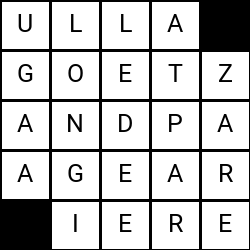

In [4]:
word_list_path = './Word List/all_answers.txt'
# word_list_path = "/content/new_answer_list.txt"

# 4x4 grid
grid = [['', 'A', 'A', 'A'],
        ['A', 'A', 'A', 'A'],
        ['A', 'A', 'A', 'A'],
        ['A', 'A', 'A', '']]

# # 5x5 grid
grid = [['A', 'A', 'A', 'a', ''],
        ['A', 'A', 'A', 'A', 'a'],
        ['a', 'A', 'A', 'A', 'a'],
        ['a', 'A', 'A', 'A', 'A'],
        ['', 'a', 'A', 'A', 'A'],]

start_t = time.time()
crossword = Crossword(grid, word_list_path)
creator = CrosswordCreator(crossword, do_random = True)
# creator = CrosswordParallelSolver(crossword, do_random = True)
assignment = creator.solve()
end_t = time.time()

print("Total time taken: ", end_t - start_t, 'seconds')
print("Total back-tracks: ", creator.ASSIGNMENT_COUNT)
print("Total time taken in revise function: ", creator.t_revise_time)
print("Total times revise function is called: ", creator.t_revise_called)
pprint(assignment)
creator.save(assignment, block_size = 50, f_size = 25)